# Question 3: From population dynamics to spectra

In questions 1 and 2 you have seen how the relative magnitudes of system and bath parameters can influence the population dynamics. But it might not be clear how, or if, these differences are observed in an experiment. Accordingly, question 3 focuses on the link between the reduced density matrix and spectroscopy experiments.

## 3.1 Preliminary steps and model definition

Ensure that qspectra is installed and remember that it only works with Python 2.7.

In [82]:
import qspectra as qs
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt

# things that make the plots more acceptable to look at
rcParams['figure.figsize'] = 5, 4 # default figure width, height in freedom units of inches
rcParams['figure.dpi'] = 150 # figure dpi
rcParams['font.size'] = 7 # text doesn't have to be huge
rcParams['axes.linewidth'] = 0.5
rcParams['xtick.major.width'] = 0.5
rcParams['ytick.major.width'] = 0.5
rcParams['legend.frameon'] = False
rcParams['legend.fontsize'] = 5.5
rcParams["image.cmap"] = 'viridis' # make colour map divergent (white at 0, growing intensity of different colours for +ve and -ve)

The model system is a molecular trimer coupled to an environment with a Debye spectral density. Each molecule has its own transition energy and is coupled to its neighbours through a dipole interaction. We will use this system to model energy transfer dynamics.

In [151]:
ham1 = qs.ElectronicHamiltonian(np.array(np.mat('12800. 140. -50.; 140. 12700. 105.; -50. 105. 12550.')), # system Hamiltonian, energy unit: cm^-1
                               bath=qs.DebyeBath(qs.CM_K * 77., 80., 120.), # bath parameters: temperature, reorganisation energy, cutoff frequency
                               dipoles=[[0.75, 0.5, 0.5], [0.5, 0.25, 1.], [0.5, 0.5, 1.]]) # dipole vectors for each molecular transition

ham2 = qs.ElectronicHamiltonian(np.array(np.mat('12800. 140. -50.; 140. 12700. 105.; -50. 105. 12550.')), # system Hamiltonian, energy unit: cm^-1
                               bath=qs.DebyeBath(qs.CM_K * 154., 160., 170.), # 2x the reorganisation energy in H1
                               dipoles=[[1.0, 0.5, 0.5], [1., 0.25, 1.], [0.75, 0.5, 1.]])

The dipole coupling means the molecular transition energies are not the transition energies of the trimer. We can calculate the eigenvalues, along with a transformation matrix that converts the system Hamiltonian from the site representation to the energy representation. This is conceptually similar to switching between the Schrödinger, interaction, and Heisenberg pictures. Moving between representations does not change the physics (although some models are basis-dependent), but it allow us to think about the dynamics in different ways. 

In the site representation, the basis vectors correspond to the excitation of a single molecule in the trimer. The energy representation involves basis vectors that correspond to the electronic states of the trimer In the context of energy transfer dynamics, the energy representation is often called the *exciton* representation. An exciton is a bound electron-hole pair, and the primary photoexcitation product in materials with weak screening, like molecular semiconductors and semiconductor quantum dots. Energy transfer corresponds to excitons moving through the system.

In [152]:
ham_evals, xform = ham1.eig(subspace='ef')
ham_evals # in cm^-1

array([12457.66732951, 12692.41435034, 12899.91832015, 25123.32311582,
       25420.91240462, 25555.76447956])

There are six eigenvalues in our chosen subspace, which includes single and double excitations. The double excitations have energies about twice that of the single excitations, and will be important later.

We can now define our models for calculating the system dynamics. The Redfield model should be familiar. It treats the system-bath interaction perturbatively, so in principle should only accurately describe systems weakly coupled to an environment. Moreover, Redfield theory assumes Markovian dynamics, where the instantaneous system dynamics are insensitive to the history of the bath evolution. It is often said that such an environment has no memory. Markovian dynamics occur when the bath correlation time is much shorter than the timescale of system dynamics.

The hierarchical equations of motion (HEOM) approach is a non-perturbative method for calculating reduced density matrix dynamics. It uses a set of connected auxiliary density operators to describe the different system-bath interactions (Markovian effects, non-Markovian effects, fluctuations, dissipation...) and how those interactions influence not only the system dynamics, but also the other system-bath interactions. The set of connected auxiliary density operators forms a hierarchy, with the reduced density operator sitting at the top. In principle, the hierarchy is infinite and the HEOM can describe arbitrarily-strong system bath interactions to an arbitrary order. Of course, the hierarchy must be truncated if the calculation is ever to finish. The truncation level depends on, amongst other things, the energies, types of system-bath interactions that must be included, and one's computational resources. For our purposes, it's sufficient to know that the HEOM, when properly truncated, are more accurate than perturbative approaches when the system-bath coupling is strong and the bath correlation time is long. 

In [153]:
rf_trimer = qs.RedfieldModel(ham1, hilbert_subspace='gef', # 'gef' means a subspace including ground states, singly excited states and doubly excited states
                           discard_imag_corr=True, # we remove the imaginary components of the system-bath correlations
                           unit_convert=qs.CM_FS)
rf_trimer2 = qs.RedfieldModel(ham2, hilbert_subspace='gef', # 'gef' means a subspace including ground states, singly excited states and doubly excited states
                           discard_imag_corr=True, # we remove the imaginary components of the system-bath correlations
                           unit_convert=qs.CM_FS)

heom_trimer = qs.HEOMModel(ham1, hilbert_subspace='gef',
                         unit_convert=qs.CM_FS,
                         level_cutoff=5, # the hierarchy level truncation
                         K=2, # the number of exponential functions used to describe the bath correlation function
                         low_temp_corr=True) # low temperature correlations
heom_trimer2 = qs.HEOMModel(ham2, hilbert_subspace='gef',
                         unit_convert=qs.CM_FS,
                         level_cutoff=5, # the hierarchy level truncation
                         K=2, # the number of exponential functions used to describe the bath correlation function
                         low_temp_corr=True) # low temperature correlations

## 3.2 Absorption spectra



### Polarisation dependence

CPU times: user 895 ms, sys: 8.09 ms, total: 903 ms
Wall time: 117 ms


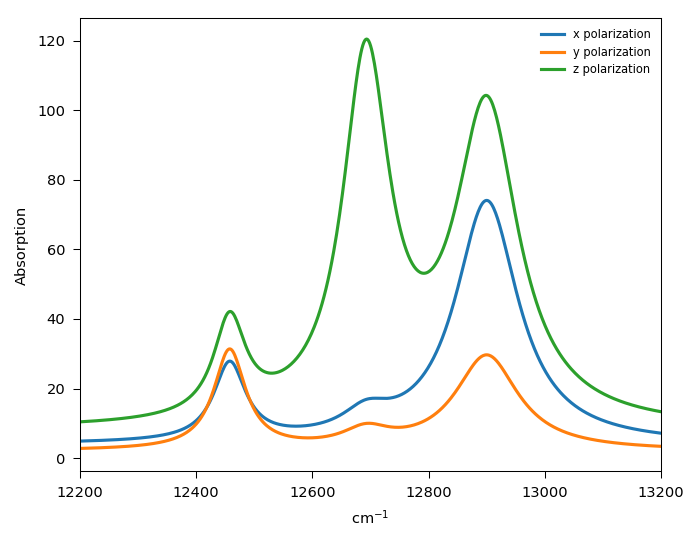

In [154]:
%%time
arfxx, lrfxx = qs.absorption_spectra(rf_trimer, polarization='xx', time_max=10000)
arfyy, lrfyy = qs.absorption_spectra(rf_trimer, polarization='yy', time_max=10000)
arfzz, lrfzz = qs.absorption_spectra(rf_trimer, polarization='zz', time_max=10000)

plt.plot(arfxx, lrfxx, label = 'x polarization')
plt.plot(arfyy, lrfyy, label = 'y polarization')
plt.plot(arfzz, lrfzz, label = 'z polarization')
plt.xlabel('cm$^{-1}$')
plt.ylabel('Absorption')
plt.xlim(12200, 13200)
plt.legend();

The dipole vectors for each molecular transition impart a strong polarisation dependence onto the trimer excitations. 

### Influence of the environment

The two Hamiltonians defined in 3.1 have spectral densities with different reorganisation energies. Let's first see how this influence the Refield spectrum.

CPU times: user 408 ms, sys: 5.49 ms, total: 414 ms
Wall time: 84.6 ms


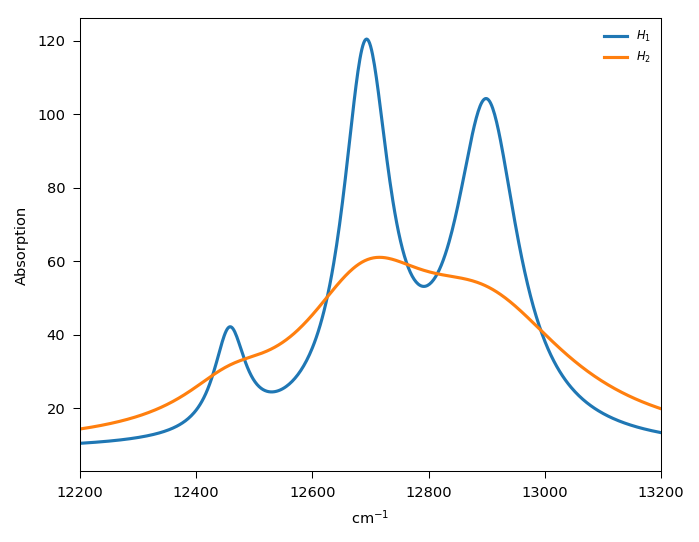

In [155]:
%%time
arfzz, lrfzz = qs.absorption_spectra(rf_trimer, polarization='zz', time_max=10000)
arfzzh2, lrfzzh2 = qs.absorption_spectra(rf_trimer2, polarization='zz', time_max=10000)

plt.plot(arfzz, lrfzz, label = '$H_{1}$')
plt.plot(arfzzh2, lrfzzh2, label = '$H_{2}$')
plt.xlabel('cm$^{-1}$')
plt.ylabel('Absorption')
plt.xlim(12200, 13200)
plt.legend();

And now the HEOM spectra.

CPU times: user 17.2 s, sys: 94.9 ms, total: 17.3 s
Wall time: 11.3 s


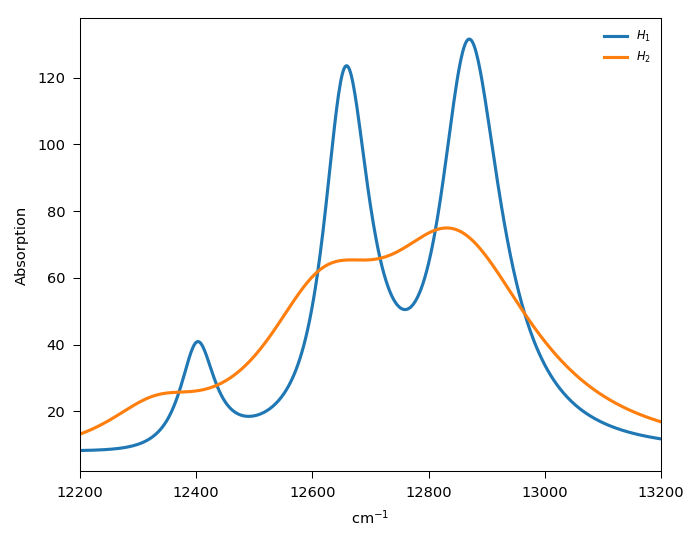

In [156]:
%%time
aheomzz, lheomzz = qs.absorption_spectra(heom_trimer, polarization='zz', time_max=10000)
aheomzzh2, lheomzzh2 = qs.absorption_spectra(heom_trimer2, polarization='zz', time_max=10000)

plt.plot(aheomzz, lheomzz, label = '$H_{1}$')
plt.plot(aheomzzh2, lheomzzh2, label = '$H_{2}$')
plt.xlabel('cm$^{-1}$')
plt.ylabel('Absorption')
plt.xlim(12200, 13200)
plt.legend();

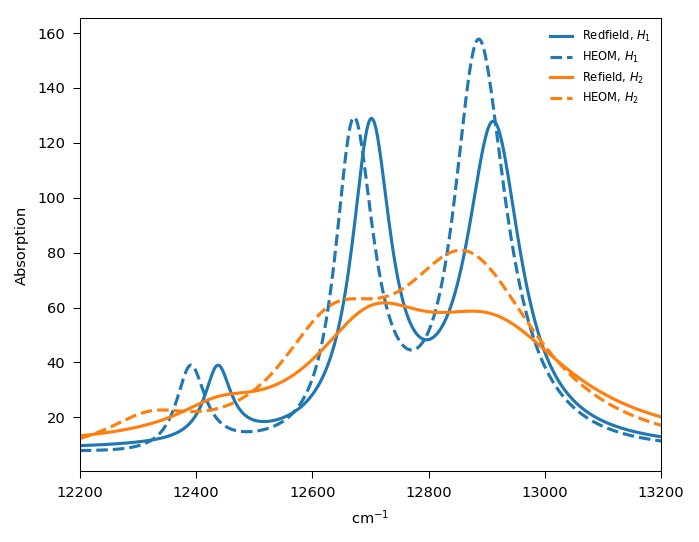

In [136]:
plt.plot(arfzz, lrfzz, 'C0-', label = 'Redfield, $H_{1}$')
plt.plot(aheomzz, lheomzz, 'C0--', label = 'HEOM, $H_{1}$')
plt.plot(arfzzh2, lrfzzh2, 'C1-', label = 'Refield, $H_{2}$')
plt.plot(aheomzzh2, lheomzzh2, 'C1--', label = 'HEOM, $H_{2}$')
plt.xlabel('cm$^{-1}$')
plt.ylabel('Absorption')
plt.xlim(12200, 13200)
plt.legend();

The HEOM and Redfield spectra are quite different, although one cannot say which method is better without experimental data.

## 3.3 State dynamics

These calculations are similar to the ones you performed for questions 1 and 2.

### Redfield dynamics

CPU times: user 24.8 ms, sys: 1.43 ms, total: 26.2 ms
Wall time: 25.1 ms


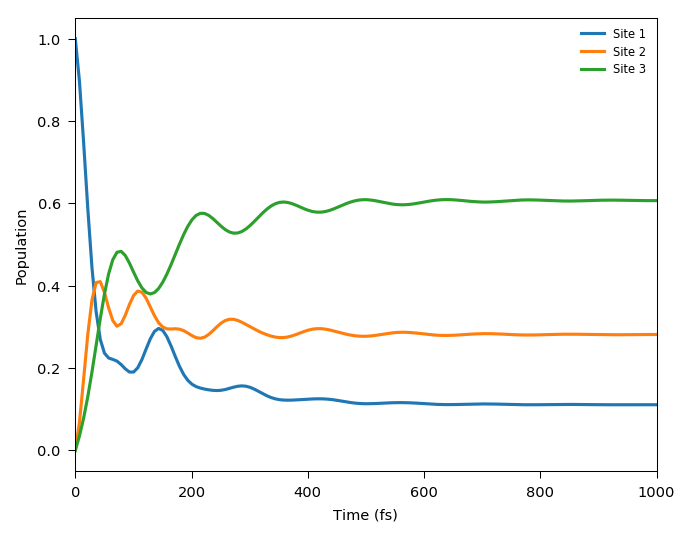

In [157]:
%%time
tr, rhorf = qs.simulate_dynamics(rf_trimer, [1., 0., 0.], 2000) # dynamics for H1, [1.,0.,0.] means the poopulation starts on site/molecule 1

plt.plot(tr, np.einsum('tii->ti', rhorf.reshape(-1, 3, 3)).real) # the density matrix must be collapsed for plotting; reshape dimensions depend on number of states
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(0, 1000)
plt.legend(['Site {}'.format(n) for n in xrange(1, 4)]);

CPU times: user 23.1 ms, sys: 1.28 ms, total: 24.4 ms
Wall time: 23.4 ms


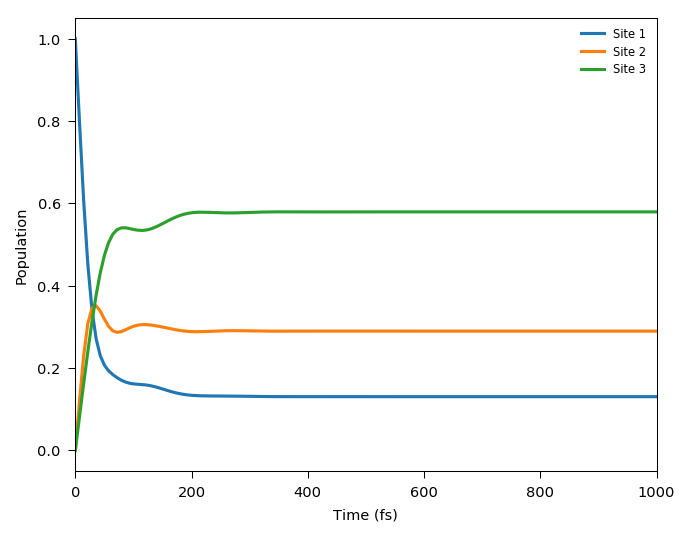

In [158]:
%%time
trh2, rhorfh2 = qs.simulate_dynamics(rf_trimer2, [1., 0., 0.], 2000)

plt.plot(trh2, np.einsum('tii->ti', rhorfh2.reshape(-1, 3, 3)).real)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(0, 1000)
plt.legend(['Site {}'.format(n) for n in xrange(1, 4)]);

### HEOM dynamics

CPU times: user 9 s, sys: 64.9 ms, total: 9.06 s
Wall time: 6.18 s


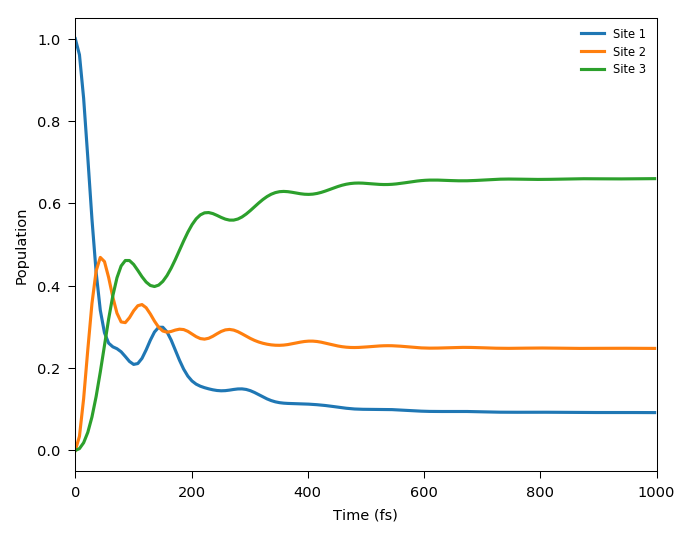

In [159]:
%%time
th, rhoheom = qs.simulate_dynamics(heom_trimer, [1., 0., 0.], 1000)

plt.plot(th, np.einsum('tii->ti', rhoheom.reshape(-1, 3, 3)).real)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(0, 1000)
plt.legend(['Site {}'.format(n) for n in xrange(1, 4)]);

CPU times: user 9.68 s, sys: 27.3 ms, total: 9.71 s
Wall time: 6.09 s


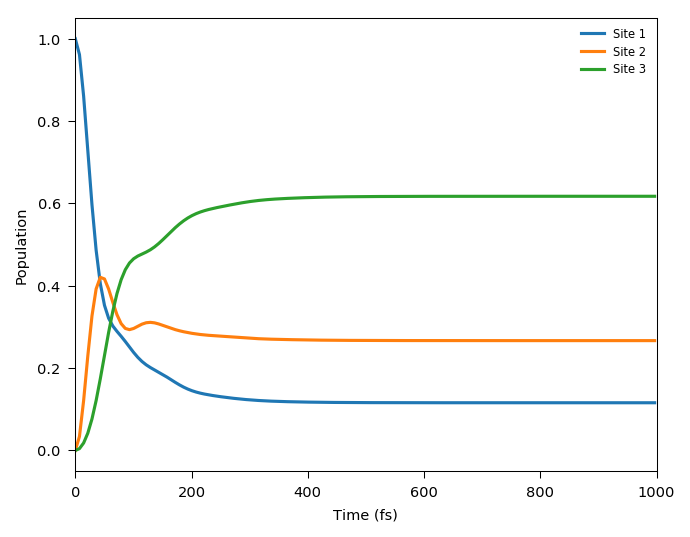

In [160]:
%%time
thh2, rhoheomh2 = qs.simulate_dynamics(heom_trimer2, [1., 0., 0.], 1000)

plt.plot(thh2, np.einsum('tii->ti', rhoheomh2.reshape(-1, 3, 3)).real)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(0, 1000)
plt.legend(['Site {}'.format(n) for n in xrange(1, 4)]);

### The influence of an excitation pulse

This is the first step towards time-dependent spectra. In all of the previous calculations we have assumed a state population at $t = 0$. Let's see how good that assumption is using a 25 fs pulse nearly resonant with the highest energy single excitation. We'll use the Redfield model with $H_{1}$.

CPU times: user 93.3 ms, sys: 2.77 ms, total: 96.1 ms
Wall time: 94.7 ms


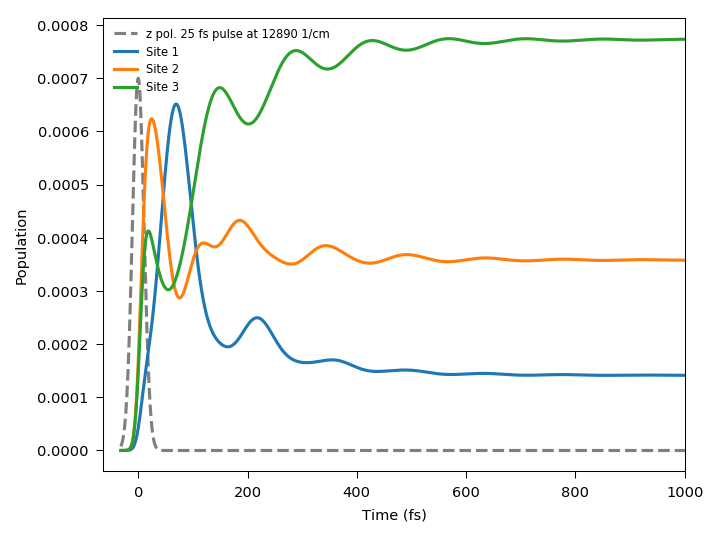

In [161]:
%%time
e0 = 12890 # pulse centre energy in cm^-1
tau = 25 # pulse FWHM duration in fs

pumprf = qs.GaussianPulse(e0, tau, scale = 1e-3, freq_convert = qs.CM_FS) # defines the pump pulse

start = 2*pumprf.t_init
end = 2000 
steps = 2000
stimes = np.linspace(start, end, steps)

tr2z, rhorf_pumpz = qs.simulate_pump(rf_trimer, pumprf, 'z', times=stimes) # calculates the pump-induced dynamics, 'x', 'y', 'z' for pump pulse polarisation

plt.plot(tr2z, 0.7 * pumprf(tr2z, e0).real, 'C7--')
plt.plot(tr2z, np.einsum('tii->ti', rhorf_pumpz.reshape(-1, 4, 4)[:, 1:, 1:]).real)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(start, end/2)
plt.legend(np.concatenate([['z pol. {} fs pulse at {} 1/cm'.format(tau, e0)], ['Site {}'.format(n) for n in xrange(1, 4)]]));

Now let's look at the influence of the pump pulse polarisation.

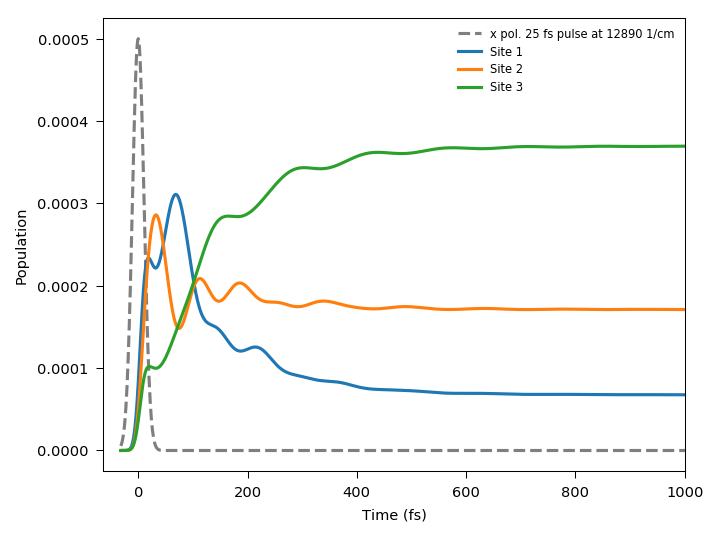

In [162]:
tr2x, rhorf_pumpx = qs.simulate_pump(rf_trimer, pumprf, 'x', times=stimes) # 'x', 'y', 'z' for pump pulse polarisation

plt.plot(tr2x, 0.5 * pumprf(tr2x, e0).real, 'C7--')
plt.plot(tr2x, np.einsum('tii->ti', rhorf_pumpx.reshape(-1, 4, 4)[:, 1:, 1:]).real)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(start, end/2)
plt.legend(np.concatenate([['x pol. {} fs pulse at {} 1/cm'.format(tau, e0)], ['Site {}'.format(n) for n in xrange(1, 4)]]));

Finally, let's examine how the pump pulse duration affects the dynamics. First, a 50 fs pulse.

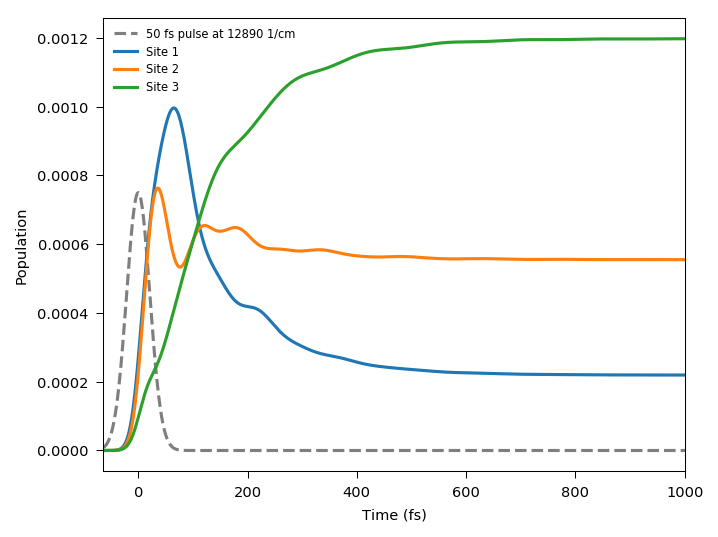

In [163]:
taus = 50 # pulse FWHM duration in fs

pumprfs = qs.GaussianPulse(e0, taus, scale = 1e-3, freq_convert = qs.CM_FS) # defines the pump pulse

starts = 2 * pumprfs.t_init
ends = 2000
stepss = 2000
sstimes = np.linspace(starts, ends, stepss)

tr2xs, rhorf_pumpxs = qs.simulate_pump(rf_trimer, pumprfs, 'x', times=sstimes) # calculates the pump-induced dynamics, 'x', 'y', 'z' for pump pulse polarisation

plt.plot(tr2xs, 0.75 * pumprfs(tr2xs, e0).real, 'C7--')
plt.plot(tr2xs, np.einsum('tii->ti', rhorf_pumpxs.reshape(-1, 4, 4)[:, 1:, 1:]).real)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(starts/2, ends/2)
plt.legend(np.concatenate([['{} fs pulse at {} 1/cm'.format(taus, e0)], ['Site {}'.format(n) for n in xrange(1, 4)]]));

Now a 100 fs pulse.

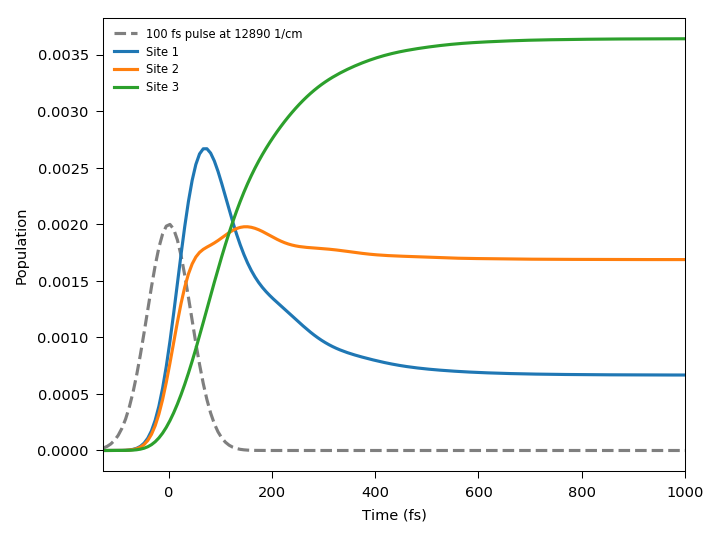

In [164]:
taul = 100 # pulse FWHM duration in fs

pumprfl = qs.GaussianPulse(e0, taul, scale = 1e-3, freq_convert = qs.CM_FS) # defines the pump pulse

startl = pumprfl.t_init
endl = 2000
stepsl = 2000
sstimes = np.linspace(startl, endl, stepsl)

tr2xl, rhorf_pumpxl = qs.simulate_pump(rf_trimer, pumprfl, 'x', 1000) # calculates the pump-induced dynamics, 'x', 'y', 'z' for pump pulse polarisation

plt.plot(tr2xl, 2 * pumprfl(tr2xl, e0).real, 'C7--')
plt.plot(tr2xl, np.einsum('tii->ti', rhorf_pumpxl.reshape(-1, 4, 4)[:, 1:, 1:]).real)
plt.xlabel('Time (fs)')
plt.ylabel('Population')
plt.xlim(startl, endl/2)
plt.legend(np.concatenate([['{} fs pulse at {} 1/cm'.format(taul, e0)], ['Site {}'.format(n) for n in xrange(1, 4)]]));

## 3.4 Time-resolved spectroscopy: transient absorption (more correctly, transient transmission)

We will use the Redfield model with $H_{1}$. The first simulation shows the different components of the transient absorption signal at a specific pump-probe delay (ca. 175 fs), using a 25 fs z polarised pump and a z polarised probe.

CPU times: user 299 ms, sys: 4.89 ms, total: 304 ms
Wall time: 119 ms


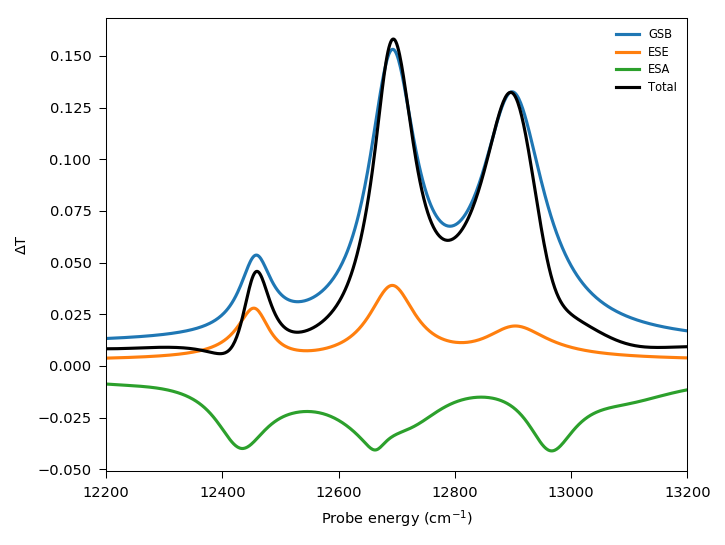

In [165]:
%%time
TAzz = {}
for signal in ['GSB', 'ESE', 'ESA']: # the signals we want to calculate; ground state bleach, stimulated emission, excited state absorption
    tazzf, TAzz[signal] = qs.impulsive_probe(rf_trimer, rhorf_pumpz[200], 10000, 'zz', include_signal=signal) # rhorf_pumpx[-1] is the final state from above, 'xx' the probe pol. 
                                                                                                                
plt.plot(tazzf, TAzz['GSB'].real, 'C0-')
plt.plot(tazzf, TAzz['ESE'].real, 'C1-')
plt.plot(tazzf, TAzz['ESA'].real, 'C2-')
plt.plot(tazzf, np.sum(TAzz.values(), 0).real, 'k-')
plt.legend(['GSB', 'ESE', 'ESA', 'Total'])
plt.xlabel('Probe energy (cm$^{-1}$)')
plt.ylabel('$\Delta$T')
plt.xlim(12200, 13200);

Let's look at how the total signal evolves using the data calculated for a 25 fs z polarised pump and z polarised probe.

CPU times: user 30.3 s, sys: 59.5 ms, total: 30.4 s
Wall time: 25.9 s


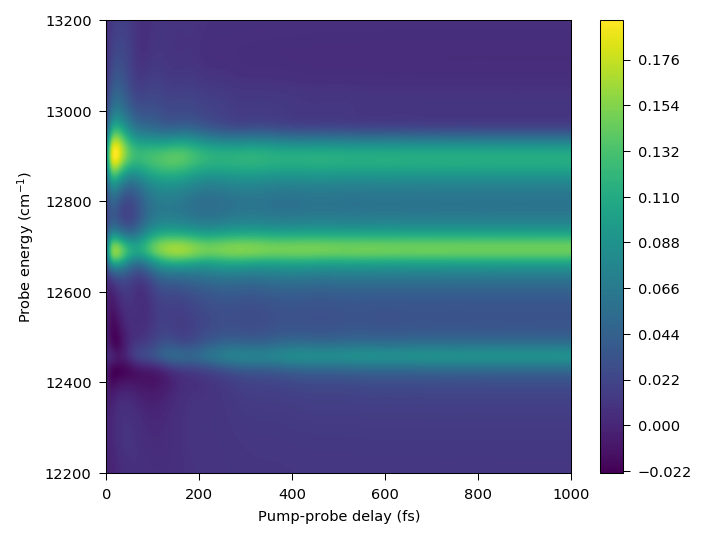

In [170]:
%%time
tazzfullf, TAzzfull = qs.impulsive_probe(rf_trimer, rhorf_pumpz, 10000, 'zz',
                          exact_isotropic_average=False, include_signal='GSB, ESE, ESA')

plt.contourf(tr2z, tazzfullf, TAzzfull.real.T, 256) # tr2z is from the dynamics simulations using an z pol. pump
# plt.plot([pumprf.t_final, pumprf.t_final], [12200, 13200], 'k--')
plt.xlim(0, 1000)
plt.ylim(12200, 13200)
plt.xlabel('Pump-probe delay (fs)')
plt.ylabel('Probe energy (cm$^{-1}$)');
plt.colorbar();

As above, but using $H_{2}$.

CPU times: user 31.7 s, sys: 56.1 ms, total: 31.8 s
Wall time: 27.2 s


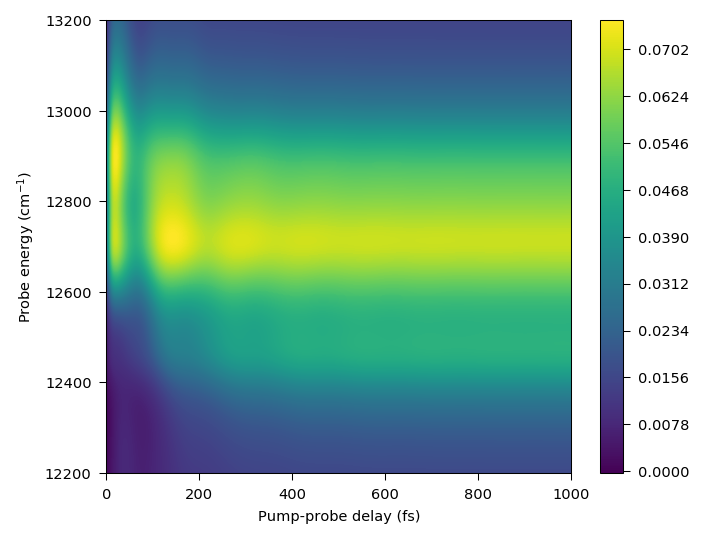

In [172]:
%%time
tazzfull2f, TAzzfull2 = qs.impulsive_probe(rf_trimer2, rhorf_pumpz, 10000, 'zz',
                          exact_isotropic_average=False, include_signal='GSB, ESE, ESA')

plt.contourf(tr2z, tazzfull2f, TAzzfull2.real.T, 256)
# plt.plot([pumprf.t_final, pumprf.t_final], [12200, 13200], 'k--')
plt.xlim(0, 1000)
plt.ylim(12200, 13200)
plt.xlabel('Pump-probe delay (fs)')
plt.ylabel('Probe energy (cm$^{-1}$)');
plt.colorbar();

## 3.5 Time-resolved spectroscopy: 2D spectra

Let's now look at the 2D spectra (coherent optical spectroscopy) of our model systems. This shows how the time-dependent response is Fourier transformed int a series of frequency-dependent spectra. We'll start with the Redfield model using $H_{1}$.

In [173]:
%%time
(tat1, tat2, tat3), X = qs.third_order_response(rf_trimer, coherence_time_max=2000,
                                          population_times=np.linspace(0, 1000, 200),
                                          polarization='zzzz',
                                          include_signal='GSB,ESE,ESA')

CPU times: user 2.47 s, sys: 102 ms, total: 2.57 s
Wall time: 2.57 s


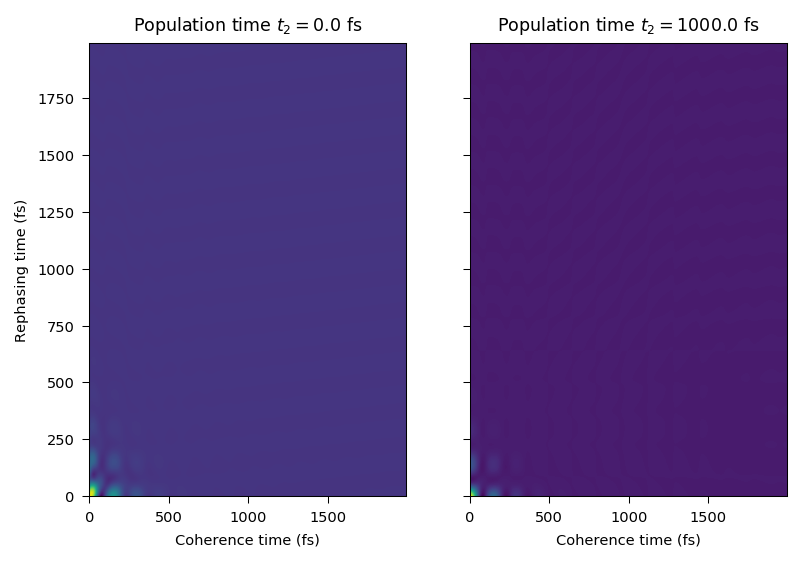

In [182]:
plt.figure(figsize=(6,4))
plt.subplot(121)
plt.title('Population time $t_{2}=%s$ fs' % tat2[0])
plt.contourf(tat1, tat3, X[:,0,:].real, 256, vmax=X.real.max());
plt.xlabel('Coherence time (fs)')
plt.ylabel('Rephasing time (fs)')
plt.subplot(122)
plt.title('Population time $t_{2}=%s$ fs' % tat2[-1])
plt.contourf(tat1, tat3, X[:,-1,:].real, 256, vmax=X.real.max());
plt.xlabel('Coherence time (fs)')
plt.gca().get_yaxis().set_ticklabels([]);

The spectra are produced at two different population times: 0 ps and 1 ps. Let's convert the axes to energy.

In [181]:
%%time
f1, X_ftt = qs.fourier_transform(tat1, X, 0, rw_freq=rf_trimer.rw_freq, sign=-1, unit_convert=qs.CM_FS)
f3, X_ftf = qs.fourier_transform(tat3, X_ftt, 2, rw_freq=rf_trimer.rw_freq, unit_convert=qs.CM_FS)

CPU times: user 52.5 s, sys: 2.12 s, total: 54.6 s
Wall time: 50 s


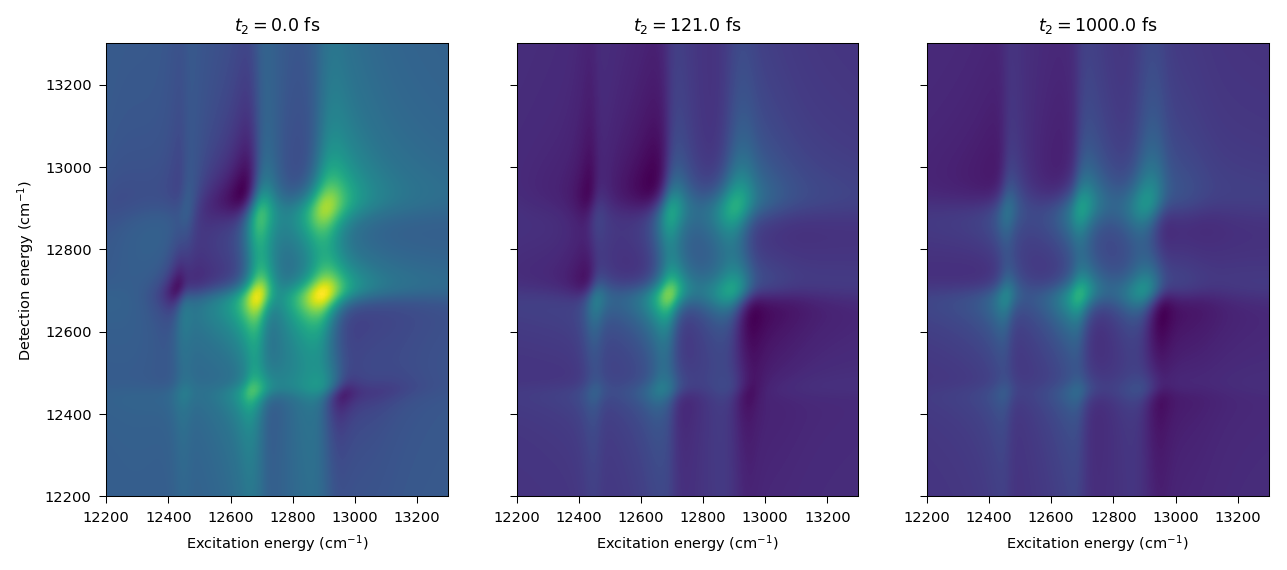

In [183]:
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.title('$t_{2}=%s$ fs' % tat2[0])
plt.contourf(f1, f3, X_ftf[:,0,:].real, 512, vmax=X_ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.ylabel('Detection energy (cm$^{-1}$)')
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

plt.subplot(132)
plt.title('$t_{2}=%s$ fs' % np.rint(tat2[24]))
plt.contourf(f1, f3, X_ftf[:,24,:].real, 512, vmax=X_ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.gca().get_yaxis().set_ticklabels([]);
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

plt.subplot(133)
plt.title('$t_{2}=%s$ fs' % tat2[-1])
plt.contourf(f1, f3, X_ftf[:,-1,:].real, 512, vmax=X_ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.gca().get_yaxis().set_ticklabels([]);
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

We can plot the diagonal elements.

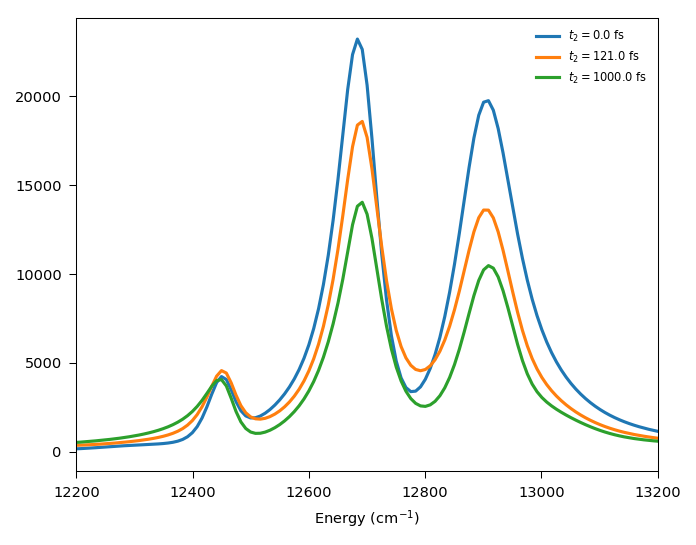

In [184]:
plt.plot(f1, np.einsum('iti->ti', X_ftf)[0].real, label='$t_{2}=%s$ fs' % np.rint(tat2[0]));
plt.plot(f1, np.einsum('iti->ti', X_ftf)[24].real, label='$t_{2}=%s$ fs' % np.rint(tat2[24]));
plt.plot(f1, np.einsum('iti->ti', X_ftf)[-1].real, label='$t_{2}=%s$ fs' % np.rint(tat2[-1]));
plt.xlabel('Energy (cm$^{-1}$)')
plt.xlim(12200, 13200);
plt.legend();

We can extract the peak positions and plot the associated dynamics. First, the diagonal peaks.

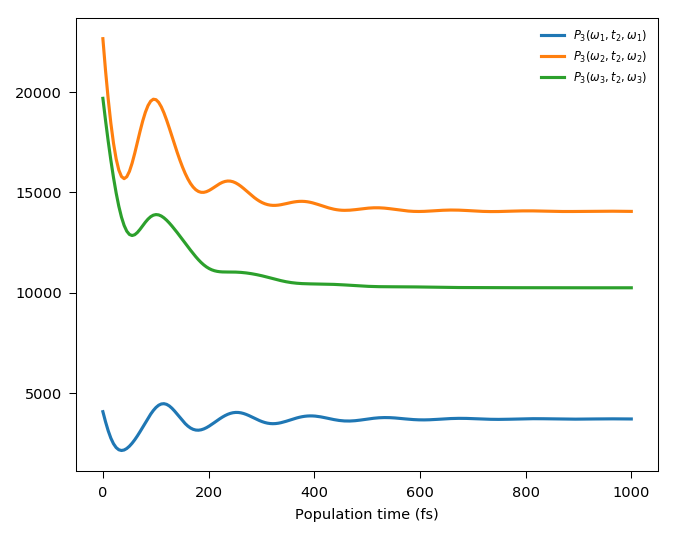

In [185]:
e1, e2, e3 = np.argmin(np.abs(f1 - ham1.E('e').reshape(-1, 1)), 1)

plt.plot(tat2, X_ftf[e1, :, e1].real, label=r'$P_3(\omega_1, t_2, \omega_1)$')
plt.plot(tat2, X_ftf[e2, :, e2].real, label=r'$P_3(\omega_2, t_2, \omega_2)$')
plt.plot(tat2, X_ftf[e3, :, e3].real, label=r'$P_3(\omega_3, t_2, \omega_3)$')
plt.xlabel('Population time (fs)')
plt.legend();

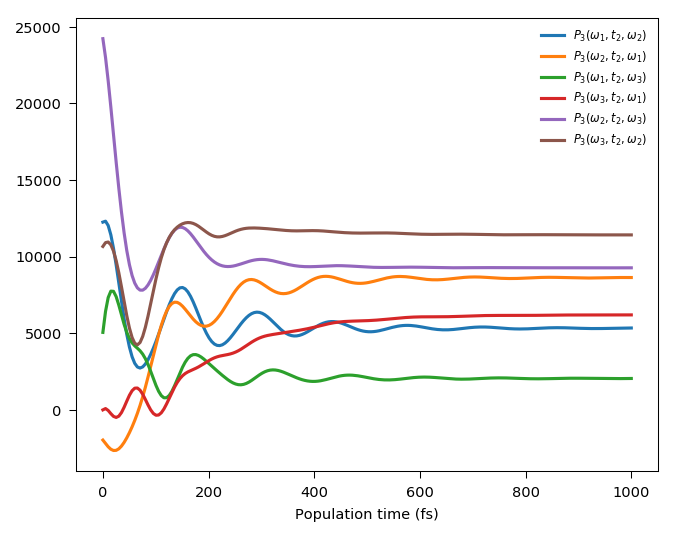

In [186]:
plt.plot(tat2, X_ftf[e1, :, e2].real, label=r'$P_3(\omega_1, t_2, \omega_2)$')
plt.plot(tat2, X_ftf[e2, :, e1].real, label=r'$P_3(\omega_2, t_2, \omega_1)$')
plt.plot(tat2, X_ftf[e1, :, e3].real, label=r'$P_3(\omega_1, t_2, \omega_3)$')
plt.plot(tat2, X_ftf[e3, :, e1].real, label=r'$P_3(\omega_3, t_2, \omega_1)$')
plt.plot(tat2, X_ftf[e2, :, e3].real, label=r'$P_3(\omega_2, t_2, \omega_3)$')
plt.plot(tat2, X_ftf[e3, :, e2].real, label=r'$P_3(\omega_3, t_2, \omega_2)$')
plt.xlabel('Population time (fs)')
plt.legend();

## Comparing models

We also have access to a function that directly calculates the 2D spectra. We'll use it to look at how the different models and Hamiltonians influence the spectra. Firstly, we'll calculate the spectra.

In [187]:
poptimes = np.linspace(0, 1000, 2)

In [188]:
%%time
(rfh1f1, rfh1t2, rfh1f3), X_rfh1ftf = qs.two_dimensional_spectra(rf_trimer, coherence_time_max = 2000, population_times = poptimes,
                                                               polarization='zzzz', include_signal='GSB,ESE,ESA')

(rfh2f1, rfh2t2, rfh2f3), X_rfh2ftf = qs.two_dimensional_spectra(rf_trimer2, coherence_time_max = 2000, population_times = poptimes,
                                                               polarization='zzzz', include_signal='GSB,ESE,ESA')

CPU times: user 6.86 s, sys: 27.5 ms, total: 6.89 s
Wall time: 1.8 s


In [189]:
%%time
(heomh1f1, heomh1t2, heomh1f3), X_heomh1ftf = qs.two_dimensional_spectra(heom_trimer, coherence_time_max = 2000, population_times = poptimes,
                                                               polarization='zzzz', include_signal='GSB,ESE,ESA')

CPU times: user 13min 53s, sys: 2.53 s, total: 13min 55s
Wall time: 2min 55s


In [190]:
%%time
(heomh2f1, heomh2t2, heomh2f3), X_heomh2ftf = qs.two_dimensional_spectra(heom_trimer2, coherence_time_max = 2000, population_times = poptimes,
                                                               polarization='zzzz', include_signal='GSB,ESE,ESA')

CPU times: user 13min 34s, sys: 2.2 s, total: 13min 36s
Wall time: 2min 51s


Now we'll look at the spectra with $t_{2} = 0$.

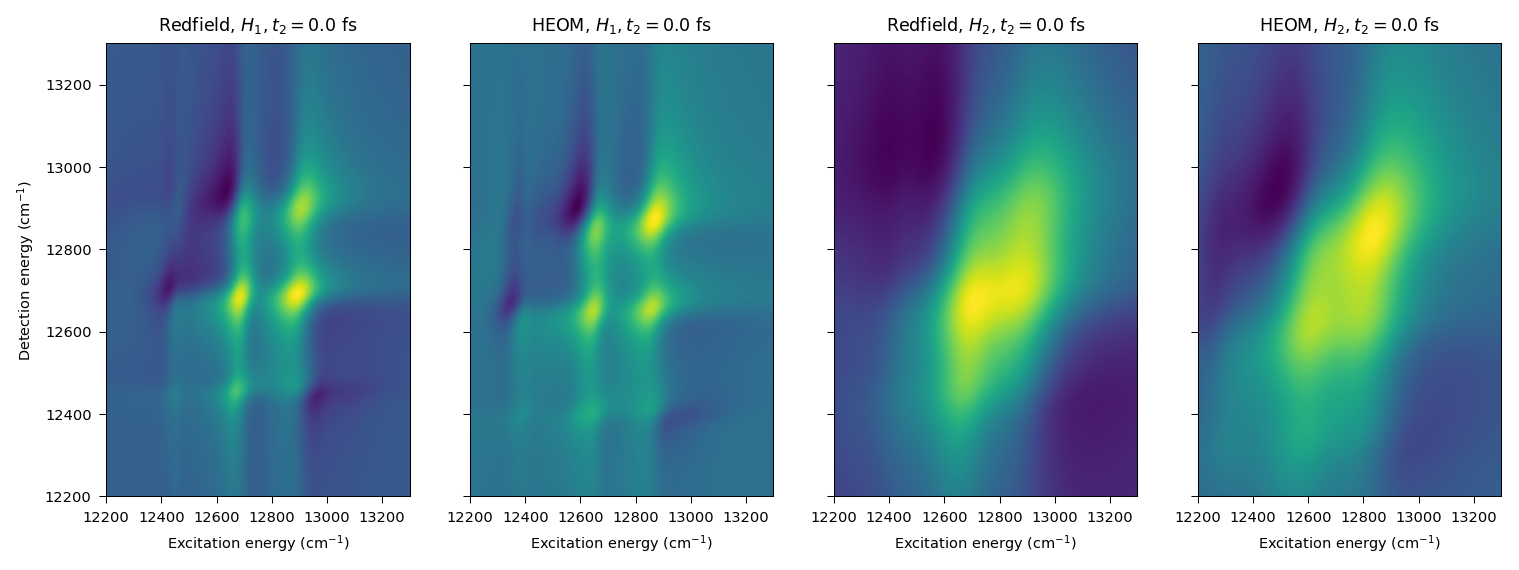

In [191]:
plt.figure(figsize=(12,4))
plt.subplot(141)
plt.title('Redfield, $H_{1}, t_{2}=%s$ fs' % rfh1t2[0])
plt.contourf(rfh1f1, rfh1f3, X_rfh1ftf[:,0,:].real, 256, vmax=X_rfh1ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.ylabel('Detection energy (cm$^{-1}$)')
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

plt.subplot(142)
plt.title('HEOM, $H_{1}, t_{2}=%s$ fs' % rfh2t2[0])
plt.contourf(heomh1f1, heomh1f3, X_heomh1ftf[:,0,:].real, 256, vmax=X_heomh1ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.gca().get_yaxis().set_ticklabels([]);
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

plt.subplot(143)
plt.title('Redfield, $H_{2}, t_{2}=%s$ fs' % heomh1t2[0])
plt.contourf(rfh2f1, rfh2f3, X_rfh2ftf[:,0,:].real, 256, vmax=X_rfh2ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.gca().get_yaxis().set_ticklabels([]);
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

plt.subplot(144)
plt.title('HEOM, $H_{2}, t_{2}=%s$ fs' % heomh2t2[0])
plt.contourf(heomh2f1, heomh2f3, X_heomh2ftf[:,0,:].real, 256, vmax=X_heomh2ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.gca().get_yaxis().set_ticklabels([]);
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

And $t_{2} = 1$ ps.

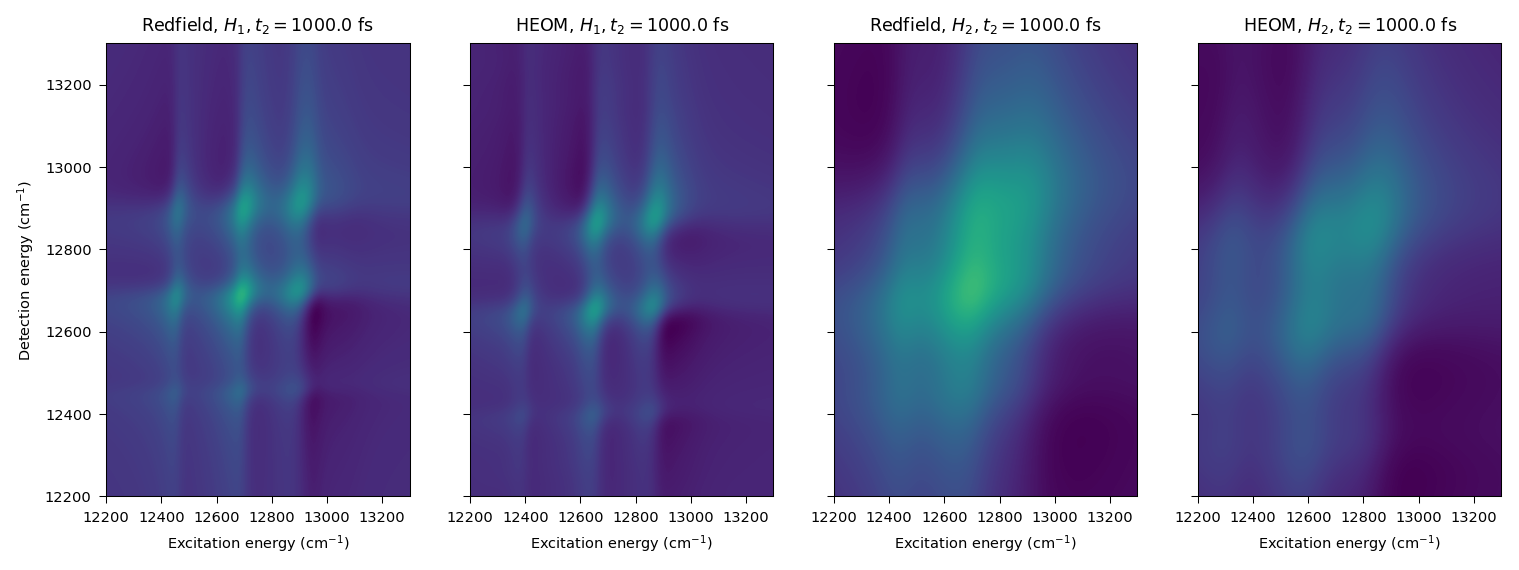

In [192]:
plt.figure(figsize=(12,4))
plt.subplot(141)
plt.title('Redfield, $H_{1}, t_{2}=%s$ fs' % rfh1t2[1])
plt.contourf(rfh1f1, rfh1f3, X_rfh1ftf[:,1,:].real, 256, vmax=X_rfh1ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.ylabel('Detection energy (cm$^{-1}$)')
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

plt.subplot(142)
plt.title('HEOM, $H_{1}, t_{2}=%s$ fs' % rfh2t2[1])
plt.contourf(heomh1f1, heomh1f3, X_heomh1ftf[:,1,:].real, 256, vmax=X_heomh1ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.gca().get_yaxis().set_ticklabels([]);
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

plt.subplot(143)
plt.title('Redfield, $H_{2}, t_{2}=%s$ fs' % heomh1t2[1])
plt.contourf(rfh2f1, rfh2f3, X_rfh2ftf[:,1,:].real, 256, vmax=X_rfh2ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.gca().get_yaxis().set_ticklabels([]);
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);

plt.subplot(144)
plt.title('HEOM, $H_{2}, t_{2}=%s$ fs' % heomh2t2[1])
plt.contourf(heomh2f1, heomh2f3, X_heomh2ftf[:,1,:].real, 256, vmax=X_heomh2ftf.real.max())
plt.xlabel('Excitation energy (cm$^{-1}$)')
plt.gca().get_yaxis().set_ticklabels([]);
plt.xlim(12200, 13300)
plt.ylim(12200, 13300);